In [1]:
from cobra.io import load_json_model
model = load_json_model("models/GEM_Recon2_thermocurated_redHUMAN.json")

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


In [2]:
import networkx as nx 
import pandas as pd
import warnings 
warnings.filterwarnings("ignore")
from cobra import Model, Reaction, Metabolite
import cobra
import numpy as np
from tqdm import tqdm
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import torch
import itertools
import copy
from cobra.util.array import create_stoichiometric_matrix
import networkx as nx
from networkx.algorithms import bipartite
import torch
#from custom_clases import GINo
import copy
import networkx as nx
import pickle
from torch.utils.data import RandomSampler
from torch.nn import Linear, LeakyReLU
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool
import numpy as np
from torch_geometric.nn.models import GIN
import numpy as np
from sklearn.model_selection import train_test_split

def cobra_a_networkx(model, undirected: bool = True):
  S_matrix = create_stoichiometric_matrix(model)

  n_mets, n_rxns = S_matrix.shape
  assert (
      n_rxns > n_mets
  ), f"Usualmente tienes mas metabolitos ({n_mets}) que reacciones ({n_rxns})"

  # Constructo raro de matrices cero
  # fmt: off
  S_projected = np.vstack(
      (
          np.hstack( # 0_mets, S_matrix
              (np.zeros((n_mets, n_mets)), S_matrix)
          ),  
          np.hstack( # S_trns, 0_rxns
              (S_matrix.T * -1, np.zeros((n_rxns, n_rxns)))
          ),
      )
  )
  S_projected_directionality = np.sign(S_projected).astype(int)
  G = nx.from_numpy_matrix(
      S_projected_directionality, 
      create_using=nx.DiGraph, 
      parallel_edges=False
  )

  # Cosas sorprendentemente no cursed
  # fmt: off
  #formulas: list[str] = [recon2.reactions[i].reaction for i in range(recon2.reactions.__len__())]
  rxn_list: list[str] = [model.reactions[i].id       for i in range(model.reactions.__len__())]
  met_list: list[str] = [model.metabolites[i].id     for i in range(model.metabolites.__len__())]

  assert n_rxns == rxn_list.__len__()
  assert n_mets == met_list.__len__()

  node_list : list[str] = met_list + rxn_list 
  part_list : list[dict[str, int]] = [{"bipartite": 0} for _ in range(n_rxns)] + [{"bipartite": 1} for _ in range(n_mets)]

  nx.set_node_attributes(G, dict(enumerate(part_list)))
  G = nx.relabel_nodes(G, dict(enumerate(node_list)))
  assert G.is_directed() 


  largest_wcc = max(nx.connected_components(nx.Graph(G)), key=len)


  # Create a subgraph SG based on G
  SG = G.__class__()
  SG.add_nodes_from((n, G.nodes[n]) for n in largest_wcc)


  SG.add_edges_from((n, nbr, d)
      for n, nbrs in G.adj.items() if n in largest_wcc
      for nbr, d in nbrs.items() if nbr in largest_wcc)

  SG.graph.update(G.graph)

  assert G.nodes.__len__() > SG.nodes.__len__()
  assert G.edges.__len__() > SG.edges.__len__()
  assert SG.nodes.__len__() == len(largest_wcc)
  assert SG.is_directed() 
  assert nx.is_connected(nx.Graph(SG))

  grafo_nx                     =copy.deepcopy(SG)
  first_partition , second_partition,   = bipartite.sets(grafo_nx)
  
  
  if first_partition.__len__() > second_partition.__len__():
      rxn_partition = first_partition
      met_partition = second_partition
  else:
      rxn_partition = second_partition 
      met_partition = first_partition
      
      
  
  assert set(rxn_partition).issubset(set(rxn_list)) and set(met_partition).issubset(set(met_list))
  if undirected:
      
      
      return  nx.Graph(grafo_nx)
  
  
  return 



In [3]:
grafo_nx = cobra_a_networkx(model)
flux_samples = pd.read_parquet("results/data/flux_samples.parquet.gzip")#.loc[0:100,:]



In [4]:


flux_dict =  flux_samples.to_dict(orient = 'list')
attrs = dict(zip(grafo_nx.nodes, itertools.repeat([])))
attrs.update(flux_dict)
nx.set_node_attributes(grafo_nx, attrs, "x")
assert grafo_nx.nodes['r0399']['x'] == flux_dict['r0399']

In [5]:
#crear_lista_de_grafos
from torch_geometric.utils.convert import from_networkx
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool
import numpy as np
from torch_geometric.nn.models import GIN
import numpy as np
from sklearn.model_selection import train_test_split


nx_G         = copy.deepcopy(grafo_nx)
x_attribute     = nx.get_node_attributes(nx_G, "x")
longest_feature = max(len(v) for k,v in x_attribute.items())
equal_len_attrs = {k:(longest_feature*[0] if len(v) == 0 else v) for k,v in x_attribute.items()}
nx.set_node_attributes(nx_G, equal_len_attrs, 'x')
assert len(set(len(v) for k,v in nx.get_node_attributes(nx_G, "x").items())) == 1
pyg_graph       = from_networkx(nx.Graph(nx_G))
assert pyg_graph.x.shape[1]  == pyg_graph.num_features == longest_feature

In [6]:
device='cpu'
target_node = 'r0399'
producto_idx = list(nx_G.nodes()).index(target_node)
producto_features = nx_G.nodes()[target_node]['x']
assert set(pyg_graph.x[producto_idx,:].numpy()).__len__() ==  set(np.array(producto_features)).__len__()
assert np.allclose(pyg_graph.x[producto_idx,:].numpy()[0:producto_features.__len__()], np.array(producto_features))

def sliding_window(ts, features,producto_idx, target_len = 1):
    X, Y = [], []
    for i in range(features + target_len, ts.shape[1] + 1):  #en este caso sería de 14+1 hasta el final de la serie 
            
            
        X.append(ts[:,i - (features + target_len):i - target_len]) #15 - 15, posicion 0 : 15-1 = 14 valores
        Y.append(ts[producto_idx, i - target_len:i]) #15-1 = 14 : 15  1 valor [14,15]
            
    return X, Y


X, y =sliding_window(pyg_graph.x, features = 1, producto_idx = producto_idx, target_len = 1)
lista_de_grafos = []

for graph_x, target in  copy.deepcopy(zip(X, y)):
    graph_x[producto_idx,:] = 0
        
    nuevo = copy.deepcopy(pyg_graph)
    nuevo.x = torch.tensor(graph_x).float()
    nuevo.y =  torch.tensor(target).float()
    lista_de_grafos.append(nuevo.to(device))

In [29]:
import gc
import torch


def make_loader(graphs: list, batch_size: int  =250, num_samples: int = 10):

    sampler_train_set = RandomSampler(
        graphs,
        num_samples= num_samples, #params["training"]["sampler_num_samples"],  # Genera un muestreo del grafo
        replacement=True,  # con repeticion de muestras
    )
    return DataLoader(graphs, batch_size=batch_size, sampler = sampler_train_set,  drop_last=True)

class regresor_GIN(torch.nn.Module):
    
    def __init__(
        self, 
        target_node_idx: int,
        n_nodes : int, 
        num_features : int, 
        out_channels: int,
        dropout : float = 0.09, 
        hidden_dim : int = 5, 
        #heads : int = 5,
        LeakyReLU_slope : float = 0.01,

        num_layers: int = 3
    ):
        super(regresor_GIN, self).__init__() # TODO: why SUPER gato? 
        self.n_nodes = n_nodes
        self.dropout = dropout
        self.num_features = num_features
        self.target_node_idx = target_node_idx
        self.out_channels = out_channels
        
        self.GIN_layers =  GIN(in_channels= num_features, hidden_channels= hidden_dim, num_layers= num_layers, out_channels= out_channels, dropout=dropout,  jk='lstm', act='LeakyReLU', act_first = True)#.to('cuda')        
        self.FC1        = Linear(in_features=out_channels, out_features=1, bias=True)#.to('cuda')
        #self.FC2        = Linear(in_features=n_nodes, out_features=1, bias=True)#.to('cuda')        #self.leakyrelu = LeakyReLU(LeakyReLU_slope).to('cuda')
        self.leakyrelu = LeakyReLU(LeakyReLU_slope)#.to('cuda')
    def forward(
        self, x, 
        edge_index, # 
        batch_size
    ):

     x     = self.GIN_layers(x, edge_index)
     x     = x.reshape(batch_size, self.n_nodes, self.out_channels)
     x     = self.FC1(self.leakyrelu(x))
        
     return  x[:,self.target_node_idx,:].squeeze()
 
 
def train(optimizer: torch.optim, loss_fun: torch.nn, modelo: regresor_GIN,loader: DataLoader, batch_size:int = 250):
    #modelo.to('cuda')

    modelo.train()
    for data in loader:
        
        with torch.cuda.device('cuda'):
             modelo.to('cuda')            
             data.to('cuda')
             prediction = modelo(data.x, data.edge_index, batch_size = batch_size)
             loss       = loss_fun(prediction, data.y)
             loss.backward()  # Derive gradients.
             optimizer.step()  # Update parameters based on gradients.
             optimizer.zero_grad()  # Clear gradients.
        #print(loss)
#    return loss
def evaluate(modelo: regresor_GIN, loss_fun: torch.nn, loader: DataLoader,  total_eval_loss: float = 0, batch_size:int = 250):
    #total_eval_loss: float = 0
    #modelo.to('cuda')

    modelo.eval()
    for data in loader:
        with torch.cuda.device('cuda'):
             modelo.to('cuda')            
             data.to('cuda')
             prediction = modelo(data.x, data.edge_index, batch_size = batch_size)
             loss_eval       = loss_fun(prediction, data.y)
             total_eval_loss += loss_eval.item()
    return total_eval_loss    
from tqdm import tqdm
def train_and_evaluate(optimizer,loss_fun, modelo, train_loader,test_loader,save_state_dict: bool = False, epochs: int = 100, min_total_loss_val: float= 1e10, verbose: bool = False, batch_size:int = 250 ):
    
    for epoch in tqdm(range(epochs)):
        gc.collect()
        torch.cuda.empty_cache()  
        
        total_eval_loss: float = 0
        train(optimizer,loss_fun, modelo,train_loader, batch_size=batch_size)
        if epoch % 1 == 0:
            total_eval_loss = evaluate(modelo,loss_fun,test_loader,total_eval_loss=total_eval_loss ,batch_size=batch_size)       
            if total_eval_loss     < min_total_loss_val:
                min_total_loss_val = total_eval_loss
                best_eval_weights  = copy.deepcopy(modelo.state_dict())
                #best_model =  copy.deepcopy(modelo.state_dict())
                if verbose:
                    print(f"NEW best min_total_loss_val {min_total_loss_val} epoch: {epoch}")
                if save_state_dict:
                    torch.save(best_eval_weights, "results/state_dicts/state_dict_best_evaluated_model.pth")
                    if verbose:
                        print(f"state_dict_best_evaluated_model.pth overwritten")
    return best_eval_weights




In [ ]:



Train_graphs, Test_graphs = train_test_split(
            lista_de_grafos,test_size=0.35,shuffle=True)

batch_size   = 5
num_samples  = 250
out_channels = 7
hidden_dim   = 7
num_layers   = 4

epochs       = 1000
n_nodes      = pyg_graph.num_nodes
train_loader = make_loader(Train_graphs, batch_size,num_samples)
test_loader  = make_loader(Test_graphs, batch_size, num_samples)
loss_fun  = torch.nn.MSELoss()


modelo = regresor_GIN(target_node_idx = producto_idx,n_nodes = n_nodes, num_features = 1, 
                      out_channels = out_channels, hidden_dim =hidden_dim, 
                      num_layers=num_layers, dropout=.1).to('cpu') 



optimizer = torch.optim.RMSprop(
    modelo.parameters(),
            lr= 0.0017681039331400813,  # Learning rate
            weight_decay= 0.0067108394238172536,  # Decaimiento de pesos
        )


In [75]:
batch_size   = 7
num_samples  = 250


epochs       = 1000
n_nodes      = pyg_graph.num_nodes
train_loader = make_loader(Train_graphs, batch_size,num_samples)
test_loader  = make_loader(Test_graphs, batch_size, num_samples)
best_eval_weights = train_and_evaluate(optimizer,loss_fun, modelo, train_loader,test_loader,save_state_dict = True,
                                       epochs = epochs, batch_size=batch_size, verbose = True)


  0%|          | 1/1000 [00:01<25:17,  1.52s/it]

NEW best min_total_loss_val 16.967087461147457 epoch: 0
state_dict_best_evaluated_model.pth overwritten


  0%|          | 2/1000 [00:02<24:46,  1.49s/it]

NEW best min_total_loss_val 12.429166581481695 epoch: 1
state_dict_best_evaluated_model.pth overwritten


  0%|          | 5/1000 [00:07<24:12,  1.46s/it]

NEW best min_total_loss_val 11.760353438949096 epoch: 4
state_dict_best_evaluated_model.pth overwritten


  1%|          | 6/1000 [00:08<24:06,  1.46s/it]

NEW best min_total_loss_val 9.38004538952373 epoch: 5
state_dict_best_evaluated_model.pth overwritten


  2%|▏         | 16/1000 [00:23<23:46,  1.45s/it]

NEW best min_total_loss_val 7.918934830930084 epoch: 15
state_dict_best_evaluated_model.pth overwritten


  2%|▏         | 21/1000 [00:30<23:00,  1.41s/it]

NEW best min_total_loss_val 7.604142726864666 epoch: 20
state_dict_best_evaluated_model.pth overwritten


  4%|▍         | 40/1000 [00:58<24:04,  1.50s/it]

<AxesSubplot:>

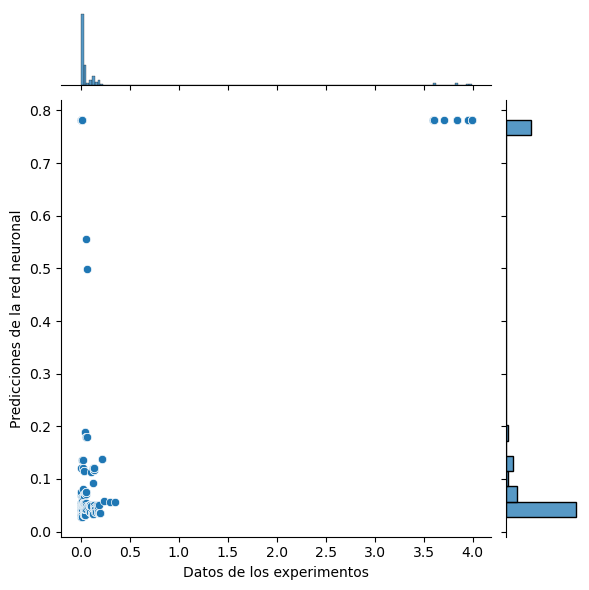

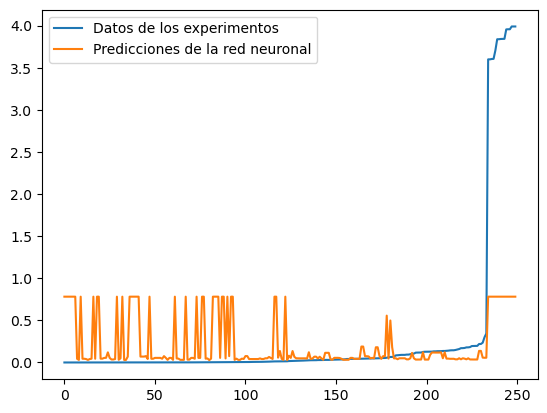

In [74]:
import seaborn as sns

modelo.load_state_dict(torch.load("results/state_dicts/state_dict_best_evaluated_model.pth"))


predictions: list = []
true_values: list = []
modelo.eval()
for data in train_loader:
    data.to('cuda')
    prediction = modelo(data.x, data.edge_index, batch_size)
    predictions.extend(prediction.squeeze().tolist())
    true_values.extend(data.y.squeeze().tolist())
    
sorted_idxs = np.argsort(true_values)

evaluation = pd.DataFrame(
        {'Datos de los experimentos': [true_values[i] for i in sorted_idxs],
        'Predicciones de la red neuronal':[predictions[i] for i in sorted_idxs]}
    ) 
sns.jointplot(x=evaluation.iloc[:,0], y = evaluation.iloc[:,1])

evaluation.plot()
